In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## 1. Load Data

In [13]:
data = pd.read_csv('/Users/ChunyanHao/desktop/github/ds_take_home/data/referral.csv')

In [5]:
data.head(3)

,user_id,date,country,money_spent,is_referral,device_id
0,2,2015-10-03,FR,65,0,EVDCJTZMVMJDG
1,3,2015-10-03,CA,54,0,WUBZFTVKXGQQX
2,6,2015-10-03,FR,35,0,CBAPCJRTFNUJG


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97341 entries, 0 to 97340
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      97341 non-null  int64 
 1   date         97341 non-null  object
 2   country      97341 non-null  object
 3   money_spent  97341 non-null  int64 
 4   is_referral  97341 non-null  int64 
 5   device_id    97341 non-null  object
dtypes: int64(3), object(3)
memory usage: 4.5+ MB


In [15]:
data['date'] = pd.to_datetime(data['date'])

In [16]:
for column in data.columns:
    uniques = data[column].unique()
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

user_id              18809	 [ 2  3  6  7 10]
date                    56	 ['2015-10-03T00:00:00.000000000' '2015-10-04T00:00:00.000000000'
 '2015-10-05T00:00:00.000000000' '2015-10-06T00:00:00.000000000'
 '2015-10-07T00:00:00.000000000']
country                  9	 ['FR' 'CA' 'UK' 'MX' 'DE']
money_spent            165	 [65 54 35 73 36]
is_referral              2	 [0 1]
device_id            17887	 ['EVDCJTZMVMJDG' 'WUBZFTVKXGQQX' 'CBAPCJRTFNUJG' 'PRGXJZAJKMXRH'
 'CVZCQLPXZCFUV']


## 2. Question 1

The program has been running for almost a month and the Growth Product Manager wants to know if it's been successful. She is very excited cause, since the referral program started, the company saw a spike in number of users and wants you to be able to give her some data she can show to her boss.

Can you estimate the impact the program had on the site?

For the purpose of showing the referral program effect, we can display in the following aspects:

1) number of users(referral or not) with transaction each day

2) total daily transaction amount, transaction by referral users

### 2.1 users increase

In [69]:
daily_user = data.groupby(['date', 'is_referral'])['user_id'].unique().reset_index()
daily_user['user_count'] = daily_user['user_id'].apply(lambda x: len(x))

user_first_day = data.groupby(['user_id', 'is_referral'])['date'].agg('min').reset_index()
#remove the first two days when all existed users are taken as new users, which is out of business sense
user_first_day = user_first_day[user_first_day.date > '2015-10-04']

[Text(0.5, 1.0, 'New User Referred or not')]

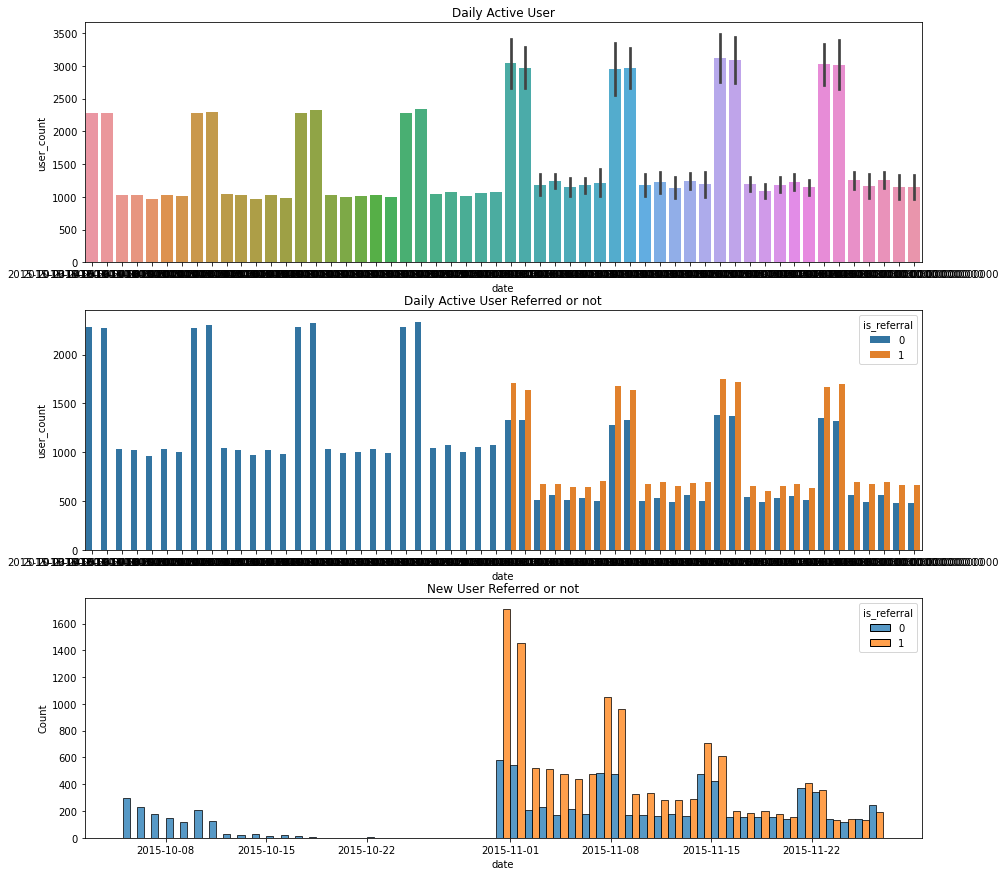

In [70]:
fig, ax = plt.subplots(3, 1, figsize = (15, 12))

sns.barplot(data = daily_user, x = 'date', y = 'user_count', 
            estimator = sum, ax = ax[0]).set(title='Daily Active User')

sns.barplot(data = daily_user, x = 'date', y = 'user_count', 
            hue = 'is_referral',  dodge = True, ax = ax[1]).set(title='Daily Active User Referred or not')

sns.histplot(data = user_first_day, x = 'date', 
             hue = 'is_referral',  multiple='dodge', ax = ax[2]).set(title='New User Referred or not')

Plots above display 3 important patterns:

1) The number of users use the website is larger in weekends than in weekdays.

2) Since the referral program started, many referred users started to spend money in the website. However, the number of non-referred users decreased significantly. But the total daily active users doesn't increase a lot.

3) As time goes by, the effect of referral program decreased gradually, because the number of new users is decreasing.

### 2.2 daily transaction amount

<AxesSubplot:xlabel='date', ylabel='money_spent'>

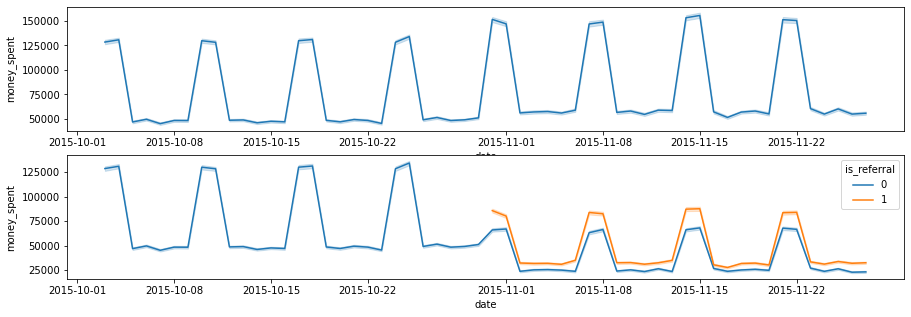

In [51]:
fig, ax = plt.subplots(2, 1, figsize = (15, 8))
sns.lineplot(data = data, x = 'date', y = 'money_spent', estimator = sum, ax = ax[0])
sns.lineplot(data = data, x = 'date', y = 'money_spent', hue = 'is_referral', estimator = sum, ax = ax[1])

The two line plots above show 3 interesting phenomenons in the daily transaction:

1) There daily transaction is significantly larger in weekends than in weekdays.

2) Since the referral program started, the total transaction amount increased a little compared with previous.

3) Since the referral program started, amount spent by non-referral users decreased significantly, while amount spent by referred users is a little bit higher than the non-referral users. There is one potential that the old users created new accounts as referred users in order to get extra $10 in credit. As the result, their previous consumption power is diluted into their now accounts.

## 3. Question 2

Based on the data, what would you suggest to do as a next step?

As analyzed above, the overall effect of this referral program doesn't seem so good. One alternative approach is to analyze the data in different segments. Because we have the information of users' country, we can then implement further analysis in the following way:

In [75]:
1 -0.95**10

0.4012630607616213